In [1]:
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import parallel_backend
import pandas as pd
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    GridSearchCV,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.linear_model import (
    LassoCV, 
    LinearRegression
) 
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    AdaBoostRegressor, 
    ExtraTreesRegressor, 
    StackingRegressor,
    VotingRegressor
)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    RobustScaler
)

# from catboost import CatBoostRegressor
# import lightgbm as lgb

In [2]:
data = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Project\used\train_2015.csv')
data['month'] = pd.to_datetime(data['month'])
data['month'] = pd.Categorical(data['month']).codes ## month-1 = 2015-01-01, month-71 = 2020-12-01
data = data.sort_values(by='month')
data

,month,floor_area_sqm,remaining_lease,MRT_distance,Mall_distance,Market_distance,Hawker_distance,CBD_distance,flat_type_2 ROOM,flat_type_3 ROOM,...,district_18,district_19,district_20,district_21,district_22,district_23,district_25,district_27,district_28,target
9903,0,68.0,68,0.616413,0.572301,0.195309,0.973689,10.690006,0,1,...,0,0,0,0,0,1,0,0,0,213864.306785
97036,0,92.0,88,0.549881,1.314058,0.073368,2.798102,10.651770,0,0,...,0,0,0,0,0,1,0,0,0,308259.587021
18530,0,66.0,57,1.166938,1.098101,0.248838,0.591166,3.741614,0,1,...,0,0,0,0,0,0,0,0,0,200589.970501
26305,0,119.0,62,0.500310,0.817207,0.309754,0.360003,11.627727,0,0,...,0,0,0,0,0,0,0,0,0,368731.563422
18515,0,123.0,67,0.784978,0.772021,0.227323,1.068829,6.144928,0,0,...,0,0,0,0,0,0,0,0,0,368731.563422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104690,71,93.0,90,0.102089,0.068752,0.043623,0.204427,7.484749,0,0,...,0,0,0,0,0,0,0,0,0,579290.369298
104688,71,91.0,90,0.102089,0.068752,0.043623,0.204427,7.484749,0,0,...,0,0,0,0,0,0,0,0,0,619116.582187
49721,71,104.0,66,1.442513,1.329439,0.526374,2.202068,13.451268,0,0,...,0,0,0,0,0,0,0,1,0,238957.277335
49197,71,120.0,65,1.338634,0.381629,0.098676,1.598508,8.840654,0,0,...,0,1,0,0,0,0,0,0,0,369297.610427


In [3]:
print("Resale price standard deviation:", np.std(data['target']))

Resale price standard deviation: 109496.8837905869


In [4]:
# plt.figure(figsize=(10,15))
# for i, feature in enumerate(['floor_area_sqm', 'remaining_lease', 'MRT_distance', 'Mall_distance', 'Hawker_distance', 'CBD_distance', 'target']):
#     plt.subplot(4, 2, i+1)
#     sns.scatterplot(x=data['month'], y=data[feature])
# plt.show()

# Data windowing

Important to split by the months, do not want contamination through the months.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [5]:
data = data.set_index('month')
X = data.drop('target', axis=1)
y = np.log1p(data['target'])

X, X_test, y, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

X_test = X_test.reset_index()
y_test = y_test.reset_index(drop=True)

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

X shape: (61269, 40)
X_test shape: (61270, 41)


In [6]:
def model_training(algorithm):
    i = 0
    scores = []
    n_splits = 10
    print('Training start...')

    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, val_idx in tscv.split(X, y):
        i += 1   
        X_train = X.iloc[train_idx, :].reset_index()
        X_val = X.iloc[val_idx, :].reset_index()
        y_train = y.iloc[train_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        y_true_test = y_test

        start_time = time.time()

        with parallel_backend('threading'):
            model = algorithm.fit(X_train, y_train)

        end_time = time.time()

        y_pred_train = np.log1p(model.predict(X_train))
        y_pred_val = np.log1p(model.predict(X_val))
        y_pred_test = np.log1p(model.predict(X_test))

        train_rmse = np.exp(mean_squared_error(y_train, y_pred_train, squared=False)).round(4)
        val_rmse = np.exp(mean_squared_error(y_val, y_pred_val, squared=False)).round(4)
        test_rmse = np.exp(mean_squared_error(y_true_test, y_pred_test, squared=False)).round(4)

        time_elapsed = round(end_time-start_time, 3)
        print(f"Fold {i}: Train RMSE = {train_rmse}, Val RMSE = {val_rmse}, Test RMSE = {test_rmse} Time elapsed = {time_elapsed}s")
        scores.append([train_rmse, val_rmse, test_rmse])
        
    scores = pd.DataFrame(scores, columns=['train_rmse', 'val_rmse', 'test_rmse'])

    plt.figure(figsize=(10,5))
    sns.lineplot(x=scores.index, y=scores['train_rmse'], label='train_rmse')
    sns.lineplot(x=scores.index, y=scores['val_rmse'], label='val_rmse')
    sns.lineplot(x=scores.index, y=scores['test_rmse'], label='test_rmse')
    plt.xticks(range(n_splits))
    plt.xlabel('folds'); plt.ylabel('scores')
    plt.show()
    return model

Training start...
Fold 1: Train RMSE = 22518.8359, Val RMSE = 22677.9865, Test RMSE = 23351.2219 Time elapsed = 0.01s
Fold 2: Train RMSE = 22592.5558, Val RMSE = 22663.5344, Test RMSE = 23202.1592 Time elapsed = 0.014s
Fold 3: Train RMSE = 22614.527, Val RMSE = 22766.874, Test RMSE = 23164.0004 Time elapsed = 0.02s
Fold 4: Train RMSE = 22651.0148, Val RMSE = 23004.8197, Test RMSE = 23139.1236 Time elapsed = 0.026s
Fold 5: Train RMSE = 22721.2712, Val RMSE = 22824.7296, Test RMSE = 23138.179 Time elapsed = 0.031s
Fold 6: Train RMSE = 22738.6101, Val RMSE = 22860.7735, Test RMSE = 23139.5148 Time elapsed = 0.037s
Fold 7: Train RMSE = 22756.2434, Val RMSE = 23143.4174, Test RMSE = 23142.1862 Time elapsed = 0.043s
Fold 8: Train RMSE = 22804.2521, Val RMSE = 23323.3896, Test RMSE = 23142.323 Time elapsed = 0.07s
Fold 9: Train RMSE = 22860.643, Val RMSE = 23425.4959, Test RMSE = 23137.1065 Time elapsed = 0.053s
Fold 10: Train RMSE = 22916.4347, Val RMSE = 23531.5511, Test RMSE = 23136.585 Ti

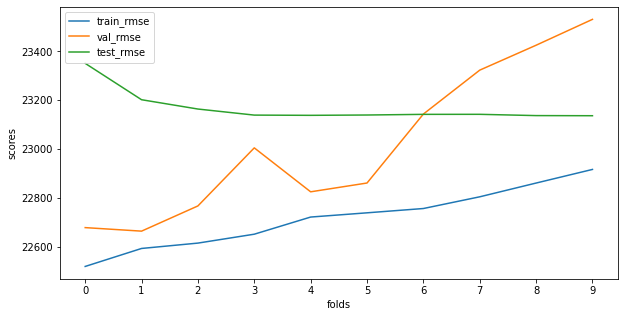

In [7]:
lr = model_training(LinearRegression())

Training start...
Fold 1: Train RMSE = 22518.0312, Val RMSE = 22668.1637, Test RMSE = 23134.9302 Time elapsed = 0.043s
Fold 2: Train RMSE = 22591.758, Val RMSE = 22661.2491, Test RMSE = 23127.4354 Time elapsed = 0.091s
Fold 3: Train RMSE = 22613.7088, Val RMSE = 22760.5337, Test RMSE = 23126.7279 Time elapsed = 0.135s
Fold 4: Train RMSE = 22650.1772, Val RMSE = 23006.4025, Test RMSE = 23133.8553 Time elapsed = 0.181s
Fold 5: Train RMSE = 22720.4151, Val RMSE = 22823.9047, Test RMSE = 23132.8982 Time elapsed = 0.23s
Fold 6: Train RMSE = 22737.734, Val RMSE = 22862.0278, Test RMSE = 23138.299 Time elapsed = 0.27s
Fold 7: Train RMSE = 22755.3505, Val RMSE = 23147.8447, Test RMSE = 23140.2632 Time elapsed = 0.322s
Fold 8: Train RMSE = 22803.3429, Val RMSE = 23323.0837, Test RMSE = 23141.5126 Time elapsed = 0.36s
Fold 9: Train RMSE = 22859.7165, Val RMSE = 23423.8346, Test RMSE = 23139.3943 Time elapsed = 0.406s
Fold 10: Train RMSE = 22915.486, Val RMSE = 23533.6175, Test RMSE = 23135.6828 

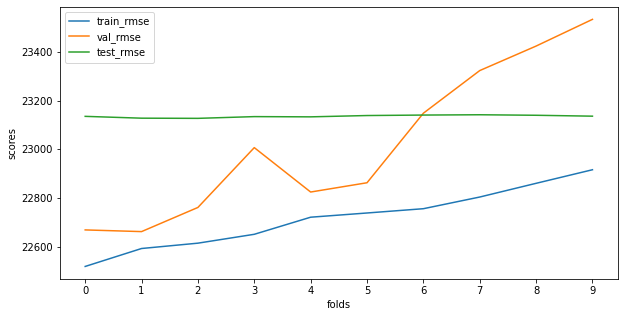

In [8]:
tree = model_training(DecisionTreeRegressor())

Training start...
Fold 1: Train RMSE = 22518.5829, Val RMSE = 22668.2251, Test RMSE = 23131.1852 Time elapsed = 0.468s
Fold 2: Train RMSE = 22592.3354, Val RMSE = 22658.0459, Test RMSE = 23127.91 Time elapsed = 0.939s
Fold 3: Train RMSE = 22614.1897, Val RMSE = 22760.5287, Test RMSE = 23129.7392 Time elapsed = 1.277s
Fold 4: Train RMSE = 22650.68, Val RMSE = 23005.417, Test RMSE = 23132.1842 Time elapsed = 1.835s
Fold 5: Train RMSE = 22720.9188, Val RMSE = 22823.5534, Test RMSE = 23132.4227 Time elapsed = 2.286s
Fold 6: Train RMSE = 22738.0578, Val RMSE = 22860.4625, Test RMSE = 23132.8156 Time elapsed = 2.771s
Fold 7: Train RMSE = 22755.6916, Val RMSE = 23141.9168, Test RMSE = 23132.252 Time elapsed = 3.006s
Fold 8: Train RMSE = 22803.6879, Val RMSE = 23320.1867, Test RMSE = 23138.7811 Time elapsed = 3.652s
Fold 9: Train RMSE = 22860.0924, Val RMSE = 23421.9141, Test RMSE = 23137.1919 Time elapsed = 3.84s
Fold 10: Train RMSE = 22915.8182, Val RMSE = 23533.7534, Test RMSE = 23140.6387 

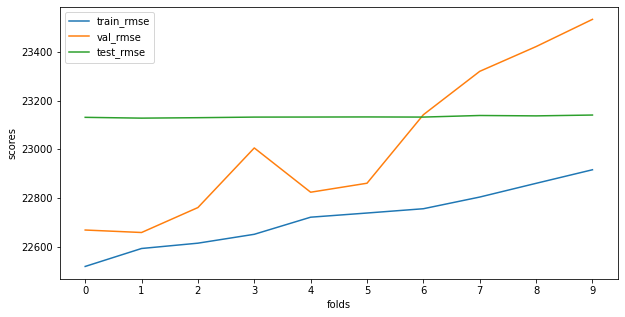

In [9]:
forest = model_training(RandomForestRegressor())

Training start...
Fold 1: Train RMSE = 22518.0312, Val RMSE = 22669.9763, Test RMSE = 23141.4092 Time elapsed = 0.36s
Fold 2: Train RMSE = 22591.758, Val RMSE = 22658.0656, Test RMSE = 23135.5263 Time elapsed = 0.615s
Fold 3: Train RMSE = 22613.7088, Val RMSE = 22759.5657, Test RMSE = 23133.5929 Time elapsed = 0.816s
Fold 4: Train RMSE = 22650.1772, Val RMSE = 23005.4104, Test RMSE = 23134.8819 Time elapsed = 1.15s
Fold 5: Train RMSE = 22720.4151, Val RMSE = 22823.2552, Test RMSE = 23131.9759 Time elapsed = 1.4s
Fold 6: Train RMSE = 22737.734, Val RMSE = 22857.9425, Test RMSE = 23133.062 Time elapsed = 1.693s
Fold 7: Train RMSE = 22755.3505, Val RMSE = 23140.3391, Test RMSE = 23133.7026 Time elapsed = 1.917s
Fold 8: Train RMSE = 22803.3429, Val RMSE = 23317.6035, Test RMSE = 23135.6525 Time elapsed = 2.195s
Fold 9: Train RMSE = 22859.7165, Val RMSE = 23420.1281, Test RMSE = 23135.2258 Time elapsed = 2.506s
Fold 10: Train RMSE = 22915.486, Val RMSE = 23532.2922, Test RMSE = 23137.1625 T

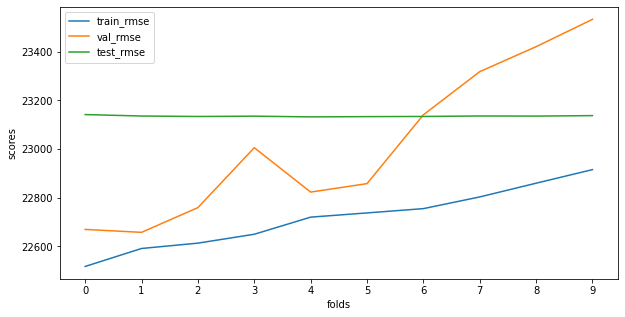

In [10]:
extra_trees = model_training(ExtraTreesRegressor())

Training start...
Fold 1: Train RMSE = 22518.6203, Val RMSE = 22664.8381, Test RMSE = 23131.5447 Time elapsed = 0.928s
Fold 2: Train RMSE = 22592.3702, Val RMSE = 22655.9932, Test RMSE = 23133.9478 Time elapsed = 1.854s
Fold 3: Train RMSE = 22614.3301, Val RMSE = 22759.9348, Test RMSE = 23132.4743 Time elapsed = 2.744s
Fold 4: Train RMSE = 22650.8178, Val RMSE = 23002.4195, Test RMSE = 23132.0211 Time elapsed = 3.615s
Fold 5: Train RMSE = 22721.0715, Val RMSE = 22822.0793, Test RMSE = 23133.0146 Time elapsed = 4.429s
Fold 6: Train RMSE = 22738.4145, Val RMSE = 22860.4328, Test RMSE = 23131.0583 Time elapsed = 5.283s
Fold 7: Train RMSE = 22756.0344, Val RMSE = 23141.1849, Test RMSE = 23131.7629 Time elapsed = 6.114s
Fold 8: Train RMSE = 22804.0525, Val RMSE = 23314.9911, Test RMSE = 23132.3342 Time elapsed = 6.988s
Fold 9: Train RMSE = 22860.4345, Val RMSE = 23420.5645, Test RMSE = 23131.8149 Time elapsed = 7.747s
Fold 10: Train RMSE = 22916.2285, Val RMSE = 23524.7143, Test RMSE = 2313

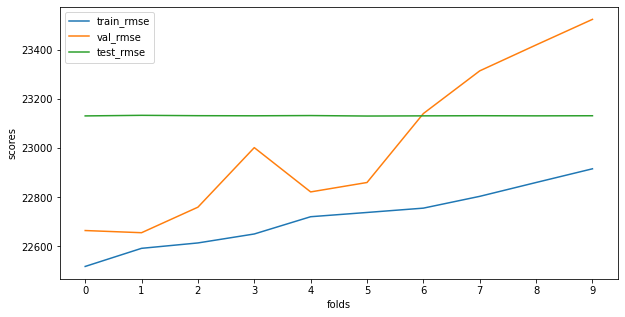

In [11]:
xgb = model_training(GradientBoostingRegressor(
    random_state=42
))

In [12]:
models = [xgb, extra_trees, lr, tree, forest]

results = []
for model in models:
    print(model)
    y_true = y_test
    y_pred = np.log1p(model.predict(X_test))
    rmse = np.exp(mean_squared_error(y_true, y_pred, squared=False)).round(4)
    results.append(rmse)
    print(rmse)

print("Ensemble results:", np.mean(results))

GradientBoostingRegressor(random_state=42)
23132.2398
ExtraTreesRegressor()
23137.1625
LinearRegression()
23136.585
DecisionTreeRegressor()
23135.6828
RandomForestRegressor()
23140.6387
Ensemble results: 23136.46176


In [13]:
# # Save model
# filename = 'xgb_model.sav'
# joblib.dump(xgb, filename)

In [14]:
# # Load model
# path = os.path.join("", filename)
# load_model = joblib.load(path)
# result = load_model.score(X_test, y_test)
# print(result)